TLS test - based on Quickstart tutorial 01

In [20]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["figure.dpi"] = 150
import batman as btm
# from bls import BLS
from astropy.stats import BoxLeastSquares as BLS
import bls
import transitleastsquares as tls
import pyconstants as cst
np.random.seed(seed=0)  # reproducibility
# np.random.seed()

From the tutorial:     
"""     
To keep it as simple as possible, this first tutorial uses synthetic data.    
This gives the possibility to change the signal shape at will.     
It also avoids downloading and de-trending real data.     
We use the batman-package (Kreidberg 2015) to generate a planet around a solar-like star with a period of ~10 days.     
The dataset is 100 days long at a cadence of 30min (as with Kepler LC).     
We add 50ppm white noise per cadence.    
"""     
Init data:

In [21]:
# Create test data
time_start = 3.14
data_duration = 100.0
samples_per_day = 48
samples = int(data_duration * samples_per_day) # 48
time = np.linspace(time_start, time_start + data_duration, samples)

In [22]:
# Use batman to create transits
ma           = btm.TransitParams()
ma.t0        = time_start  # time of inferior conjunction; first transit is X days after start
ma.per       = 10.123  # orbital period
# ma.rp        = 6371.0 / 696342.0  # 6371 planet radius (in units of stellar radii)
ma.rp        = cst.Rjups  # 6371 planet radius (in units of stellar radii)
ma.a         = 19.0  # semi-major axis (in units of stellar radii)
ma.inc       = 90.0  # orbital inclination (in degrees)
ma.ecc       = 0.0  # eccentricity
ma.w         = 90.0  # longitude of periastron (in degrees)
ma.u         = [0.4, 0.4]  # limb darkening coefficients
ma.limb_dark = "quadratic"  # limb darkening model
m = btm.TransitModel(ma, time)  # initializes model
synthetic_signal = m.light_curve(ma)  # calculates light curve

In [23]:
# Create noise and merge with flux
ppm = 50.0  # Noise level in parts per million
noise = np.random.normal(loc=0.0, scale=10.0**-6 * ppm, size=int(samples))
flux = synthetic_signal + noise

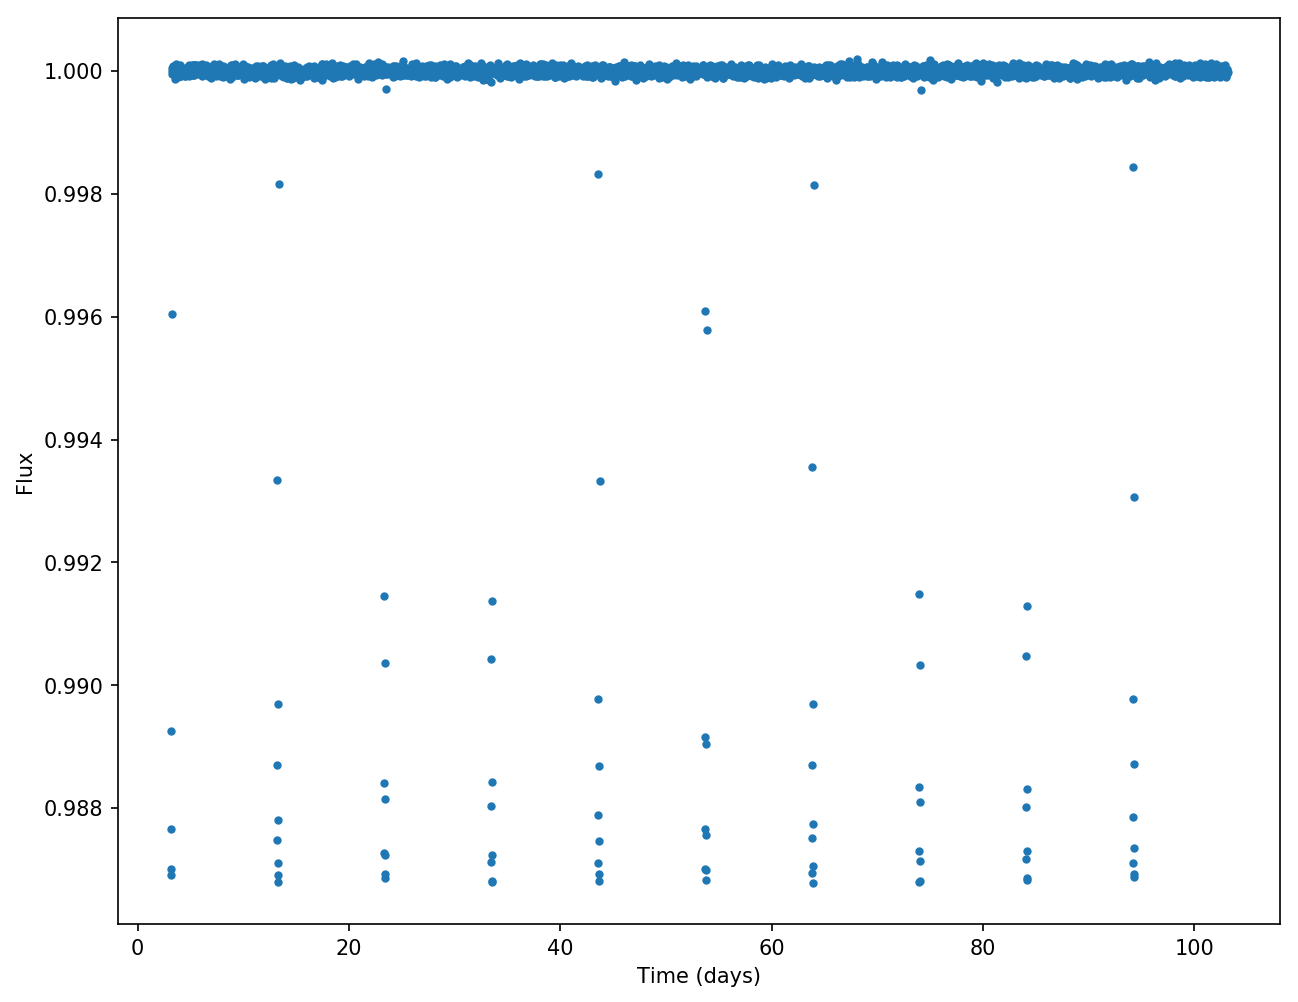

In [25]:
# Plot raw data
# plt.figure()
# ax = plt.gca()
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(time, flux, color='C0', marker='o', ms=3, ls='')
ax.set_ylabel("Flux")
ax.set_xlabel("Time (days)")
# plt.xlim(min(time), max(time))
# ax.set_ylim(0.9998, 1.0003)
plt.show()

In [26]:
# TLS
model = tls.transitleastsquares(time, flux)
results = model.power()

Transit Least Squares TLS 1.0.12 (07 January 2019)
Creating model cache for 37 durations
Searching 4800 data points, 10870 periods from 0.602 to 50.0 days, using all 4 CPU threads


100%|██████████| 10870/10870 periods | 01:13<00:00


In [27]:
# Summary results
print('Period {:.5f} d'.format(results.period))
print('{:d} transit times in time series:'.format(len(results.transit_times)), \
        ['{0:0.5f}'.format(i) for i in results.transit_times])
print('Transit depth {:.5f}'.format(1.0 - results.depth))
print('Best duration {:.5f} days = {:.3f} min'.format(results.duration, results.duration*1440.0))
print('Signal detection efficiency (SDE): {}'.format(results.SDE))

Period 10.12473 d
9 transit times in time series: ['13.26262', '23.38735', '33.51208', '43.63681', '53.76154', '63.88627', '74.01100', '84.13573', '94.26046']
Transit depth 0.01341
Best duration 0.18443 days = 265.572 min
Signal detection efficiency (SDE): 102.89248339643997


In [28]:
# Test with the astropy.stats -> BLS (Kovacs -> dfm implementation in bls.py)
m_bls = BLS(time, flux)
durs = np.linspace(0.1, 0.5, 37, endpoint=True)
# res_bls = m_bls.autopower(durs, frequency_factor=5.0)
# TLS: 10870 periods from 0.602 to 50.0 days
# per_in = np.linspace(0.602, 50.0, 10870)
per_in = results.periods
res_bls = m_bls.power(per_in, durs)

In [29]:
id_max = np.argmax(res_bls.power)
period = res_bls.period[id_max]
depth  = res_bls.depth[id_max]
dur    = res_bls.duration[id_max]
t0     = res_bls.transit_time[id_max] + period
tt     = res_bls.transit_time[id_max]
# Summary results
stats_bls = m_bls.compute_stats(period, dur, t0)
print('Period {:.5f} d'.format(period))
print('transit time: {} + period = {}'.format(tt, t0))
print('Transit depth {:.5f}'.format(depth))
print('Best duration {:.5f} days = {:.3f} min'.format(dur, dur*1440.0))
print('Stats:')
for k,v in stats_bls.items():
    print('{:s} = {}'.format(k, v))
# print('Signal detection efficiency (SDE): {}'.format(results.SDE))

Period 10.12473 d
transit time: 3.125270472432147 + period = 13.25
Transit depth 0.01148
Best duration 0.16000 days = 230.400 min
Stats:
transit_times = [ 3.12527047 13.25       23.37472953 33.49945906 43.62418858 53.74891811
 63.87364764 73.99837717 84.12310669 94.24783622]
per_transit_count = [4 8 7 7 8 8 8 8 8 8]
per_transit_log_likelihood = [0.00030062 0.00053002 0.00049913 0.00051574 0.00047051 0.00050081
 0.0005284  0.00054765 0.00054864 0.00053162]
depth = (0.01159350368193035, 0.11715421009529378)
depth_phased = (-1.0122538703249973e-05, 0.11490044825205421)
depth_half = (0.0056763419373100366, 0.0826898819554206)
depth_odd = (0.011581534619003464, 0.16965560409537697)
depth_even = (0.011604245148659986, 0.16078750284323828)
harmonic_amplitude = 0.0003800801661176567
harmonic_delta_log_likelihood = -0.004724593689754787


In [39]:
# BLS (dfm implementation in python-bls)
fmin, fmax = 1.0/per_in.max(), 1.0/per_in.min()
nf = np.shape(per_in)[0]
df = (fmax-fmin)/nf
qmi, qma = durs[0], durs[-1]
# nb = int(np.shape(time)[0]/10.0)
nb = 100
power_kbls, best_period_kbls, best_power_kbls, depth_kbls, q_kbls, in1, in2 = \
    bls.eebls(time, flux, np.zeros((len(time))), np.zeros((len(time))), nf, fmin, df, nb, qmi, qma)
dur_kbls = q_kbls * best_period_kbls

In [40]:
print('Fmin = {} (Pmax = {}) Fmax = {} (Pmin = {}) dF = {}'.format(fmin, per_in.max(), fmax, per_in.min(), df))
print('Period {:.5f} d'.format(best_period_kbls))
# print('transit time: {}'.format(tt))
print('Transit depth {:.5f}'.format(depth_kbls))
print('Best duration {:.5f} days = {:.3f} min'.format(dur_kbls, dur_kbls*1440.0))

Fmin = 0.020000000000000014 (Pmax = 49.999999999999964) Fmax = 1.6624290212002955 (Pmin = 0.6015294411053934) dF = 0.00015109742605338506
Period 3.37431 d
Transit depth 0.00187
Best duration 0.33743 days = 485.900 min


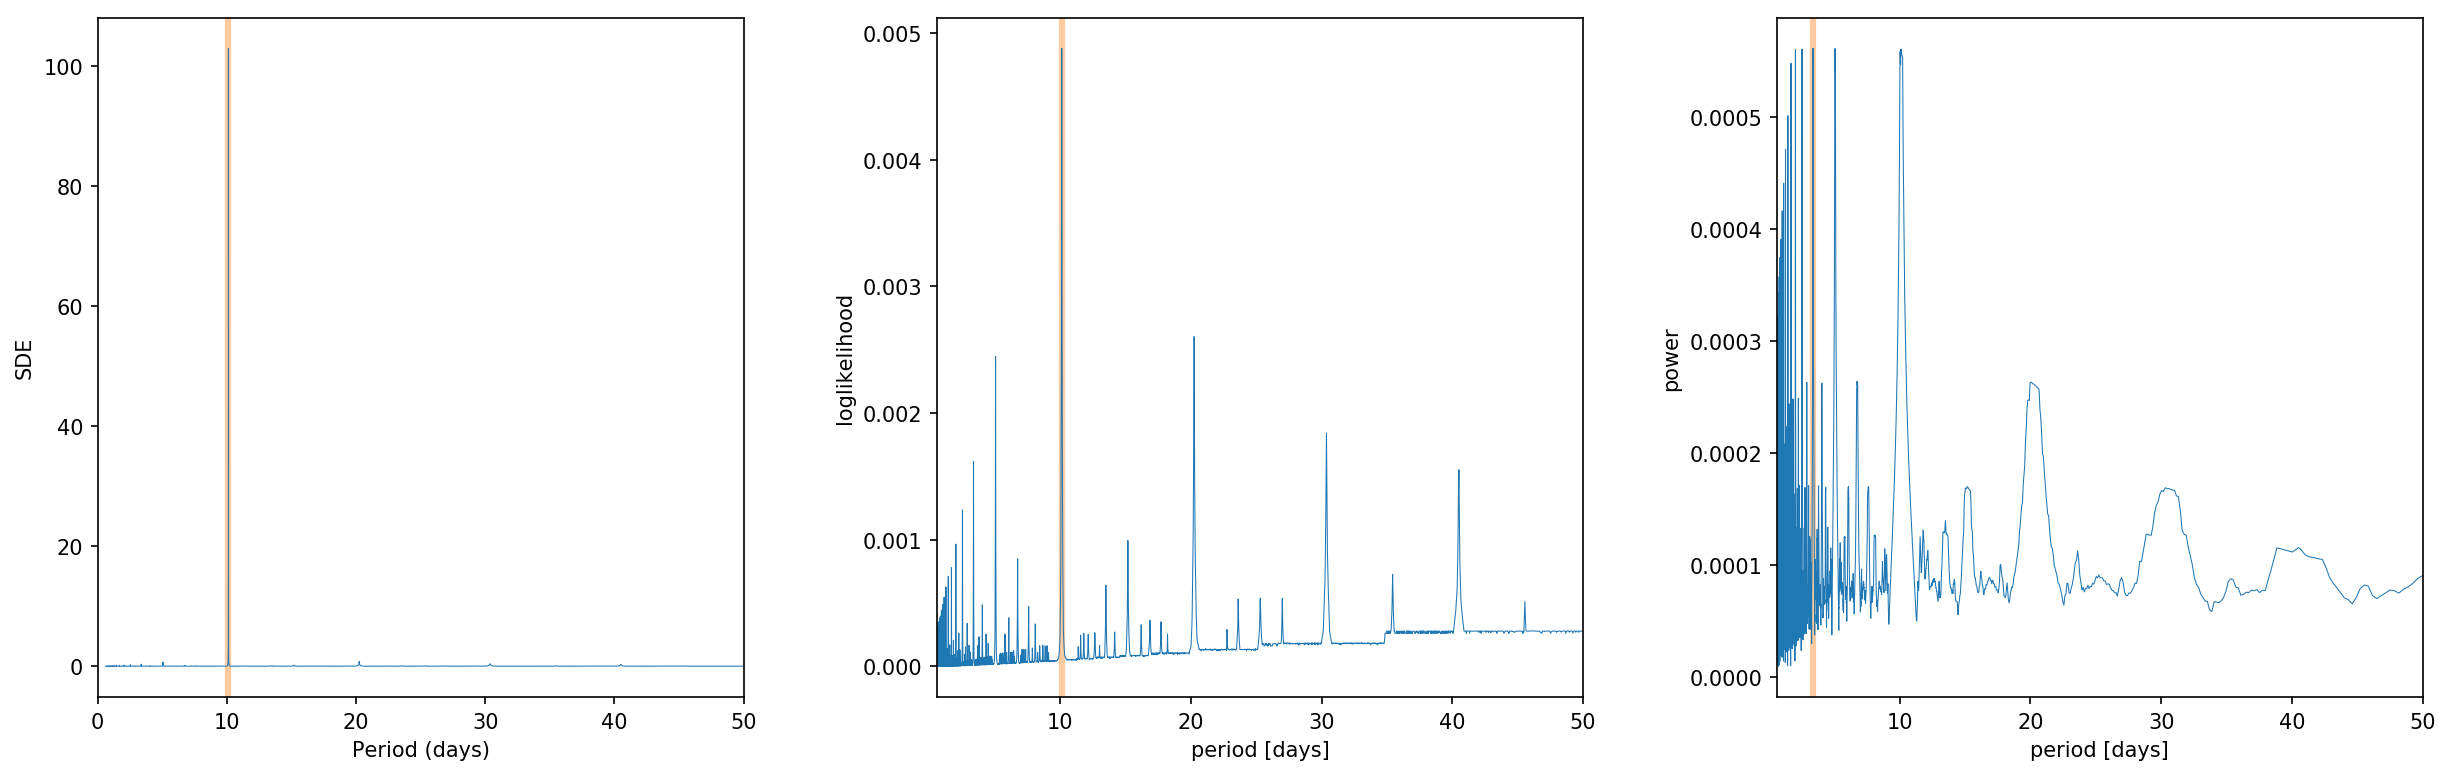

In [41]:
# Visualize the results:
# TLS
# Period vs SDE
# plt.figure()
# ax = plt.gca()
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fig.subplots_adjust(wspace=0.3)

ax[0].axvline(results.period, color='C1', alpha=0.4, lw=3)
ax[0].set_ylabel(r'SDE')
ax[0].set_xlabel('Period (days)')
ax[0].plot(results.periods, results.power, color='C0', lw=0.5)
ax[0].set_xlim(0, max(results.periods))

# BLS
# Period vs LogLikelihood
# Highlight the harmonics of the peak period
ax[1].axvline(period, color='C1', alpha=0.4, lw=3)
# Plot the periodogram
ax[1].plot(res_bls.period, res_bls.power, color='C0', lw=0.5)
ax[1].set_xlim(res_bls.period.min(), res_bls.period.max())
ax[1].set_ylabel(r'loglikelihood')
ax[1].set_xlabel("period [days]")

# BLS
# Period vs power
f_kbls = fmin + np.arange(nf) * df
p_kbls = 1.0/f_kbls
ax[2].axvline(best_period_kbls, color='C1', alpha=0.4, lw=3)
# Plot the periodogram
ax[2].plot(p_kbls, power_kbls, color='C0', lw=0.5)
ax[2].set_xlim(p_kbls.min(), p_kbls.max())
ax[2].set_ylabel(r'power')
ax[2].set_xlabel("period [days]")

plt.show()

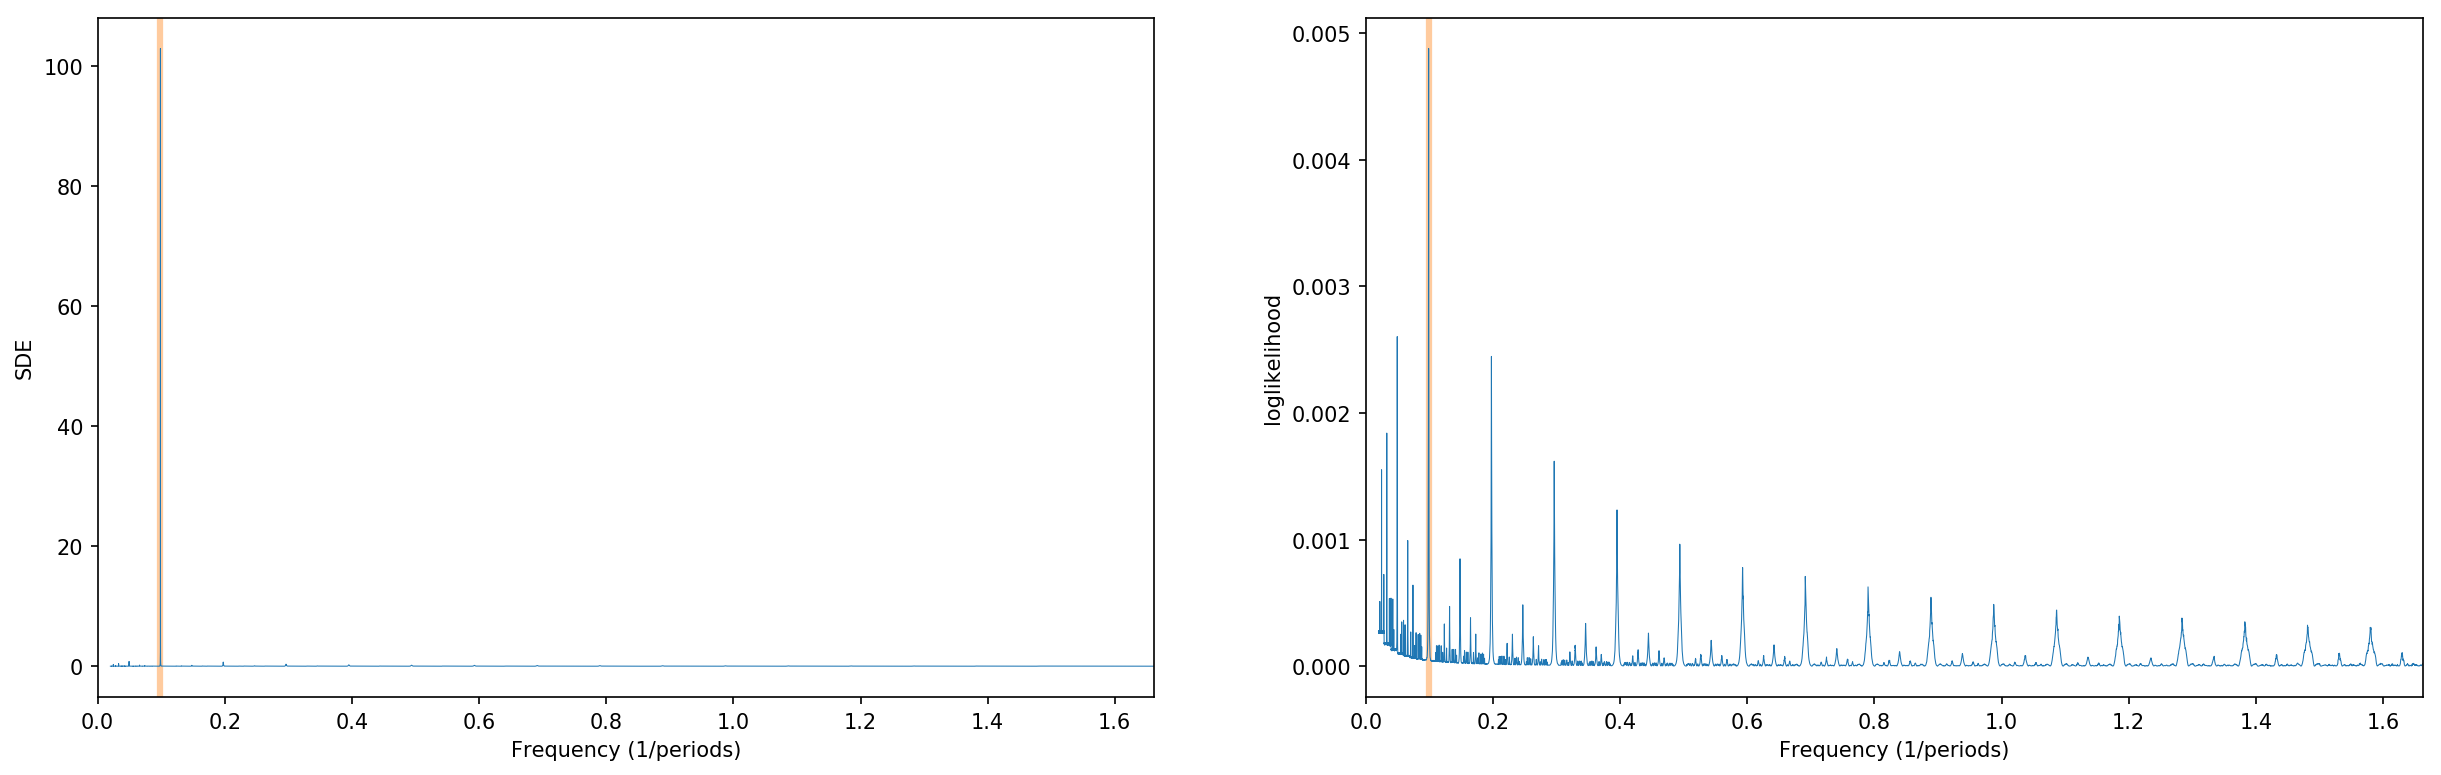

In [33]:
# TLS
# Freq vs SDE
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

freq_best = 1.0 / (results.period)
freq      = 1.0 / (results.periods)
ax[0].axvline(freq_best, color='C1', alpha=0.4, lw=3)
ax[0].set_ylabel(r'SDE')
ax[0].set_xlabel('Frequency (1/periods)')
ax[0].plot(freq, results.power, color='C0', lw=0.5)
ax[0].set_xlim(0.0, np.max(freq))

# BLS
# Frequency vs LogLikelihood
freq_best = 1.0 / (period)
freq      = 1.0 / (res_bls.period)
ax[1].axvline(freq_best, color='C1', alpha=0.4, lw=3)
# Plot the periodogram
ax[1].plot(freq, res_bls.power, color='C0', lw=0.5)
ax[1].set_xlim(0.0, freq.max())
ax[1].set_ylabel(r'loglikelihood')
ax[1].set_xlabel('Frequency (1/periods)')
plt.show()

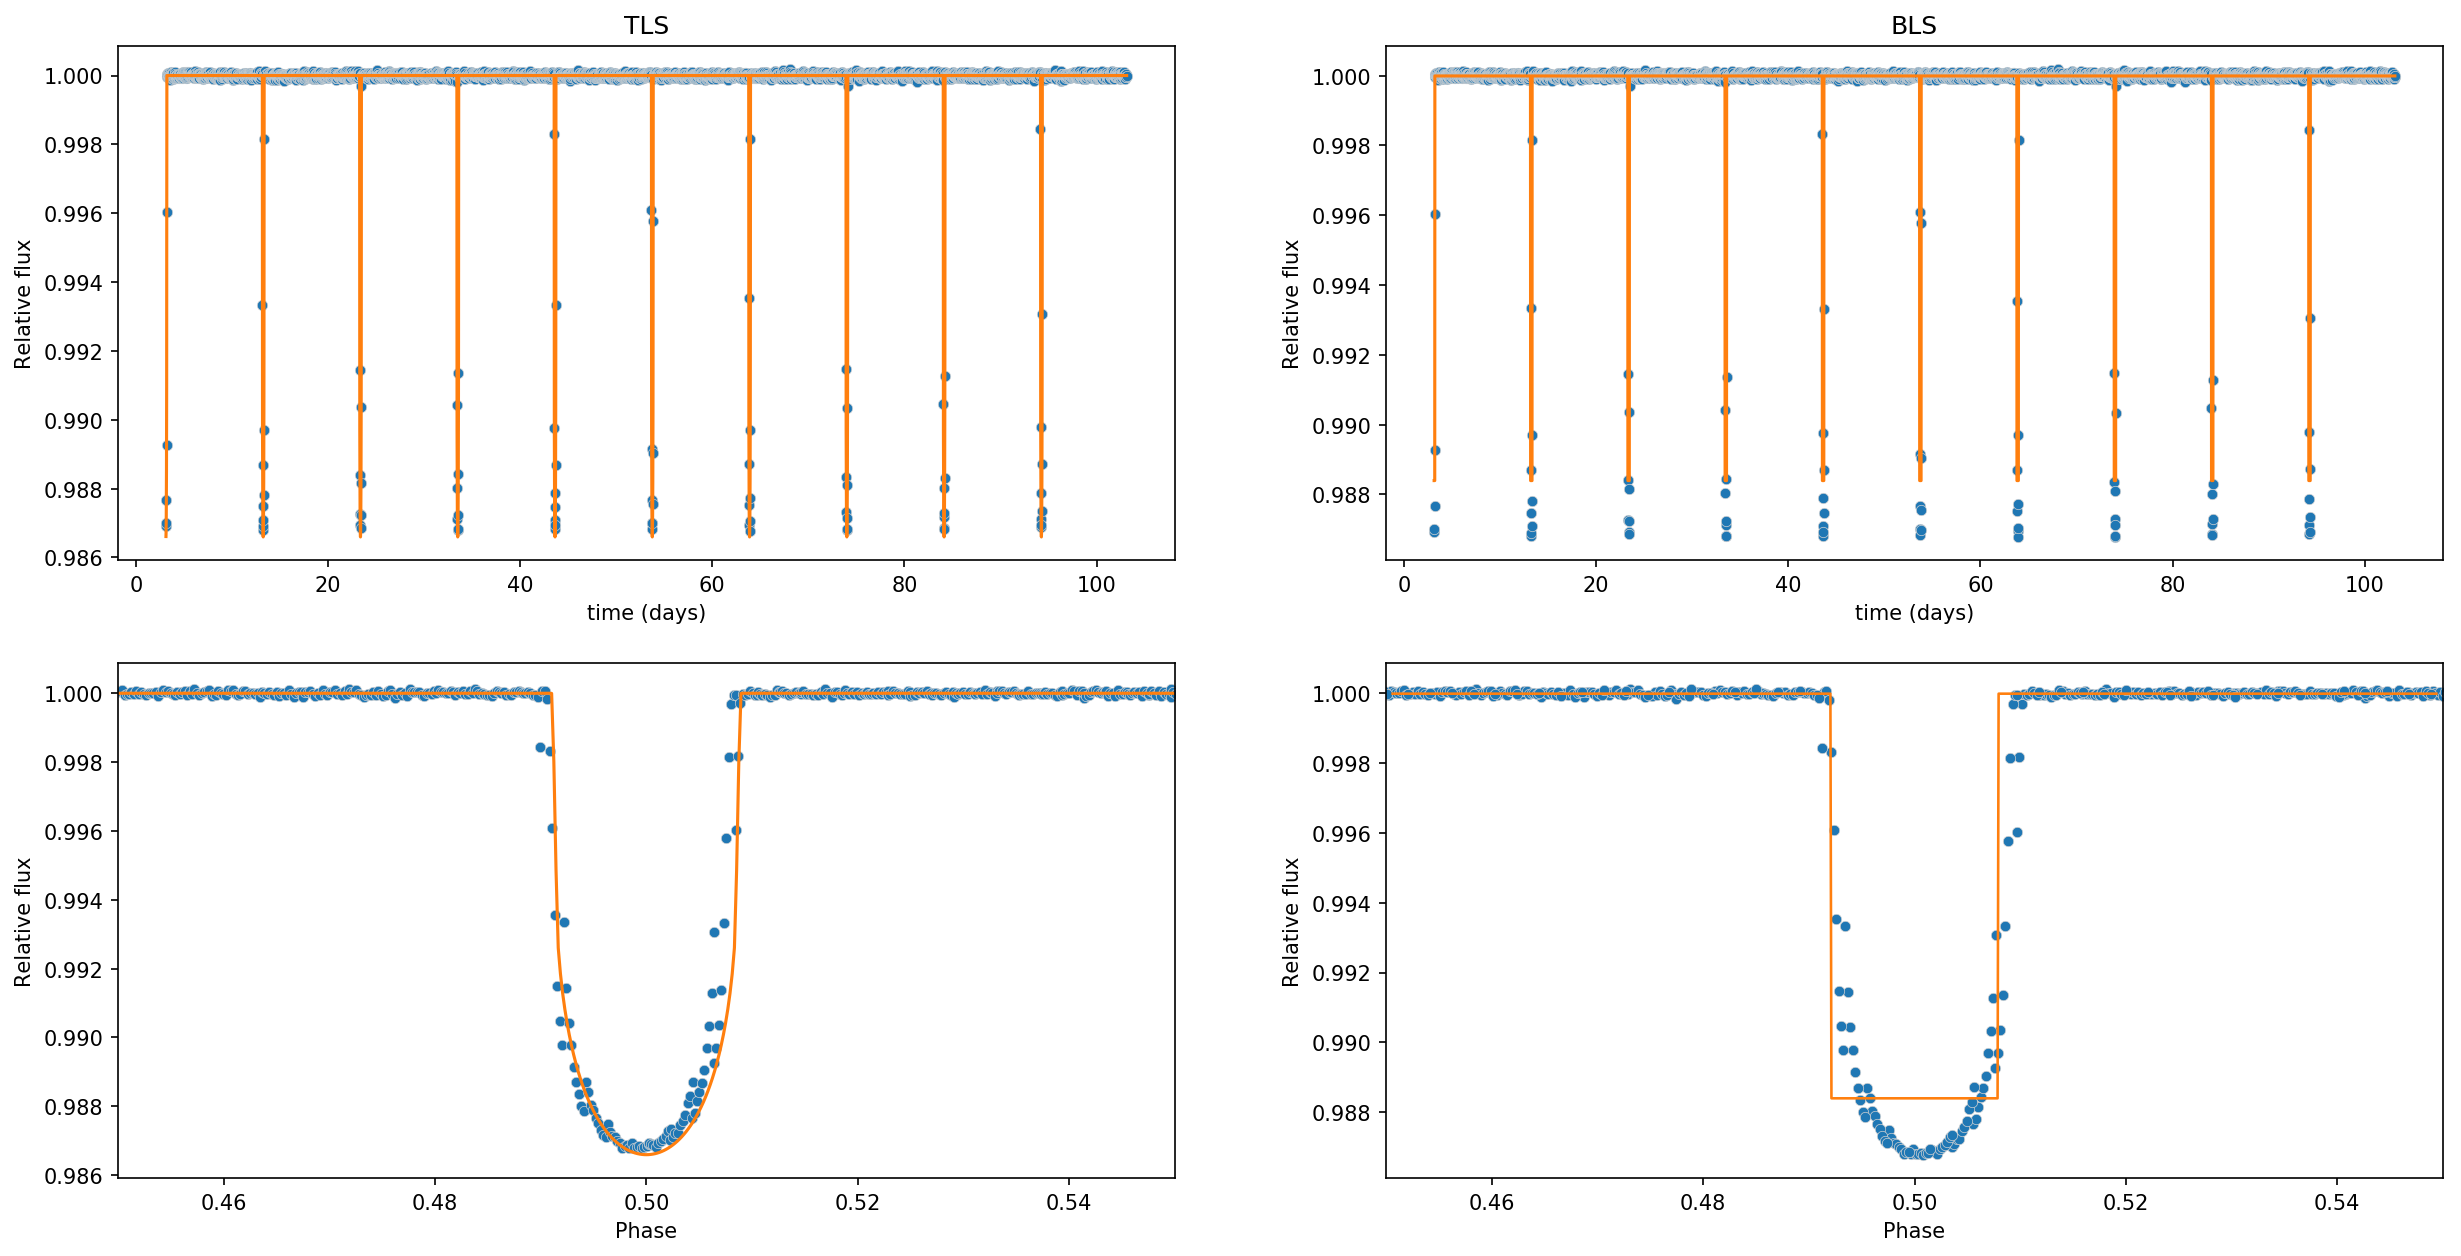

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
# fig.subplots_adjust(wspace=0.3)
# TLS - data + transits

ax[0,0].set_title('TLS')
ax[0,0].plot(time, flux, color='C0', marker='o', mec='lightgray', mew=0.33, ms=5, ls='')
ax[0,0].plot(results.model_lightcurve_time, results.model_lightcurve_model, color='C1', marker='None', ls='-', lw=1.5)
ax[0,0].set_xlabel('time (days)')
ax[0,0].set_ylabel('Relative flux')

ax[0,1].set_title('BLS')
tbls = np.linspace(time.min(), time.max(), 3*len(time))
fbls = m_bls.model(tbls, period, dur, t0)
ax[0,1].plot(time, flux, color='C0', marker='o', mec='lightgray', mew=0.33, ms=5, ls='')
ax[0,1].plot(tbls, fbls, color='C1', marker='None', ls='-', lw=1.5)
ax[0,1].set_xlabel('time (days)')
ax[0,1].set_ylabel('Relative flux')

# folded lc
# TLS
ax[1,0].plot(results.folded_phase, results.folded_y, color='C0', marker='o', mec='lightgray', mew=0.33, ms=5, ls='')
ax[1,0].plot(results.model_folded_phase, results.model_folded_model, color='C1', marker='None', ls='-', lw=1.5)
ax[1,0].set_xlim(0.45, 0.55)
ax[1,0].set_xlabel('Phase')
ax[1,0].set_ylabel('Relative flux')
# # BLS
# ph_bls = ((time - tt) / period - np.floor((time - tt) / period) + 0.5)%1.0
ph_bls_d = (time - tt + 0.5*period) % period - 0.5*period
ph_bls = (ph_bls_d/period+0.5)%1.0
x_bls_d = np.linspace(-0.5, 0.5, 1000)
x_bls = (x_bls_d/period+0.5)%1.0
f_bls = m_bls.model(x_bls_d + tt, period, dur, tt)
# ax[1,1].plot((ph_bls/period+0.5)%1.0, flux, color='C0', marker='o', mec='lightgray', mew=0.33, ms=5, ls='')
# ax[1,1].plot((x_bls/period+0.5)%1.0, f_bls, color='C1', marker='None', ls='-', lw=1.5)
ax[1,1].plot(ph_bls, flux, color='C0', marker='o', mec='lightgray', mew=0.33, ms=5, ls='')
ax[1,1].plot(x_bls, f_bls, color='C1', marker='None', ls='-', lw=1.25)
ax[1,1].set_xlim(0.45, 0.55)
ax[1,1].set_xlabel('Phase')
ax[1,1].set_ylabel('Relative flux')

plt.show()